# Feature Engineering
_This notebook focuses on transforming raw variables into meaningful features for modeling churn, enhancing predictive power based on EDA insights_

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [417]:
data = pd.read_csv('../data/cleaned_data.csv')
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [418]:
print("Dataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nData Info:")
data.info()
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (7043, 20)

Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup 

## Feature Creation

### Create tenure group feature
Splitting tenure into diffrent categories can be useful as we know from EDA that low tenue user has higher chance of churn. Flagging new user appropiately may be an indication toward churn

In [419]:
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 6, 12, 24, 48, 60, 72], labels=['0–6', '6–12', '12–24', '24–48', '48–60', '60–72'])

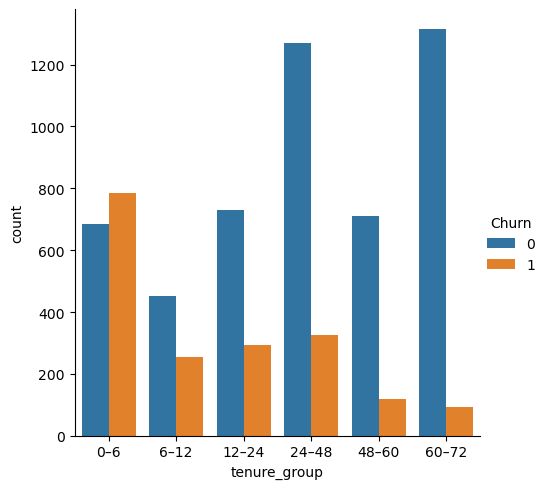

In [420]:
sns.catplot(data, x='tenure_group', hue='Churn', kind='count')

as seen from the visualization, customer with 0-6 tenure has significantly high churn rate, we can create new feature to capture this segment

In [421]:
data['new_customer'] = (data['tenure_group'] == '0–6').astype(int)

### Auto-pay flag
Frictionless payment is key that is correlated with churn rate. Automatic payment lower the tendency to churn

In [422]:
autopay_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
data['is_autopay'] = data['PaymentMethod'].apply(lambda x: 1 if x in autopay_methods else 0)

<Axes: xlabel='is_autopay'>

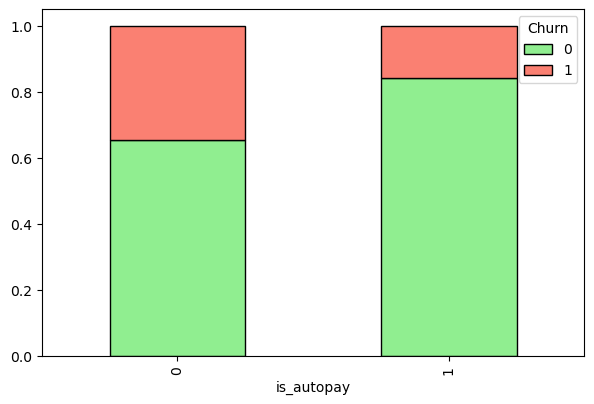

In [423]:
prop_df = (data.groupby(['is_autopay', 'Churn']).size() / data.groupby('is_autopay').size()).unstack().fillna(0)
prop_df.plot(kind='bar', stacked=True, figsize=(7, 4.5), color=['lightgreen', 'salmon'], edgecolor='black')

### Number of services
Number of additional services a user subscribes to represents the customer's ecosystem depth. A low or high number may signal different usage behaviors or cost sensitivities

In [424]:
data['AddOnCount'] = (data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

Furthermore, we can categorized grouping of customers based on number of add-ons. This introduces coarser granularity to AddOnCount, helping identify clusters with shared digital engagement levels

In [425]:
data['AddOnGroup'] = pd.cut(data['AddOnCount'], bins=[-1, 0, 2, 6], labels=['None', 'Low', 'High'])

In [426]:
pd.crosstab(data['AddOnGroup'], data['Churn'])

Churn,0,1
AddOnGroup,,
None,1744,475
Low,1187,812
High,2243,582


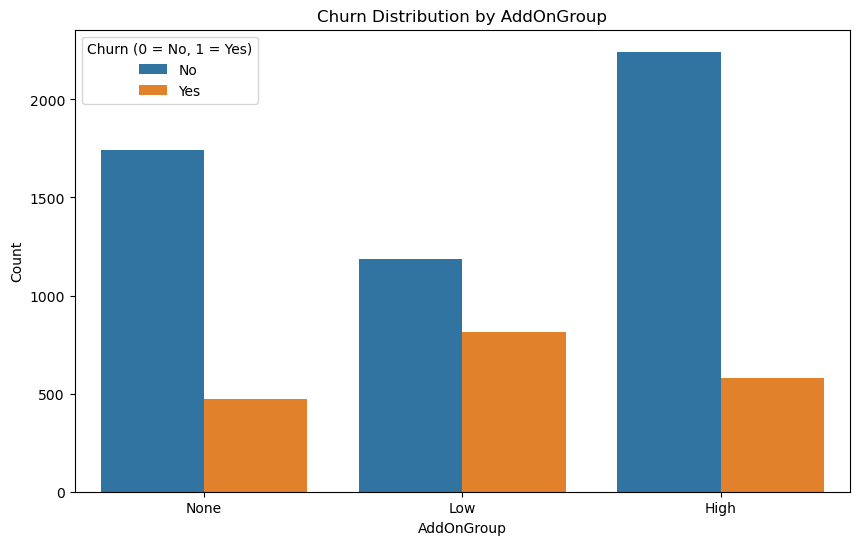

In [427]:
# Validation
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='AddOnGroup', hue='Churn')
plt.title('Churn Distribution by AddOnGroup')
plt.xlabel('AddOnGroup')
plt.ylabel('Count')
plt.legend(title='Churn (0 = No, 1 = Yes)', labels=['No', 'Yes'])
plt.show()

### Whether a user has Fiber Optic internet with Streaming TV service
This compound feature may highlight high-bandwidth demand, potentially correlating with premium usage patterns or dissatisfaction if service fails to meet expectations

In [428]:
data['FiberOptic_StreamingTV'] = (data['InternetService'] == 'Fiber optic') & (data['StreamingTV'] == 'Yes')

### Flag for senior citizens on a month-to-month contract
 this group might represent higher churn risk due to flexibility and possibly lower tech affinity

In [429]:
data['Senior_Contract'] = ((data['SeniorCitizen'] == 1) & (data['Contract'] == 'Month-to-month')).astype(int)

### Binning Monthly Charges into Categorical Groups
KDE plot from EDA suggest that customer who pays 70+ has high churn likelihood. Therefore, this captures spending behavior in a more structured way. It may help models better distinguish between customer segments based on billing levels and their likelihood to churn.

In [430]:
bins = [0, 40, 70, 100, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
data['MonthlyCharges_group'] = pd.cut(data['MonthlyCharges'], bins=bins, labels=labels)


### Binary flag for users on a month-to-month plan and paying via electronic check
This combo captures a known high-risk churn cluster—flexible contracts paired with less secure, less user-friendly payment methods

In [431]:
data["M2M_ElectronicCheck"] = (
    (data["Contract"] == "Month-to-month") & 
    (data["PaymentMethod"] == "Electronic check")
)

### Customer with Fiber Optic internet but no support
this could reflect service vulnerability, increasing the chance of dissatisfaction or dropout

In [432]:
data["Fiber_NoTechSupport"] = (
    (data["InternetService"] == "Fiber optic") & 
    (data["TechSupport"] == "No")
)

## Feature Selection and Correlation Analysis

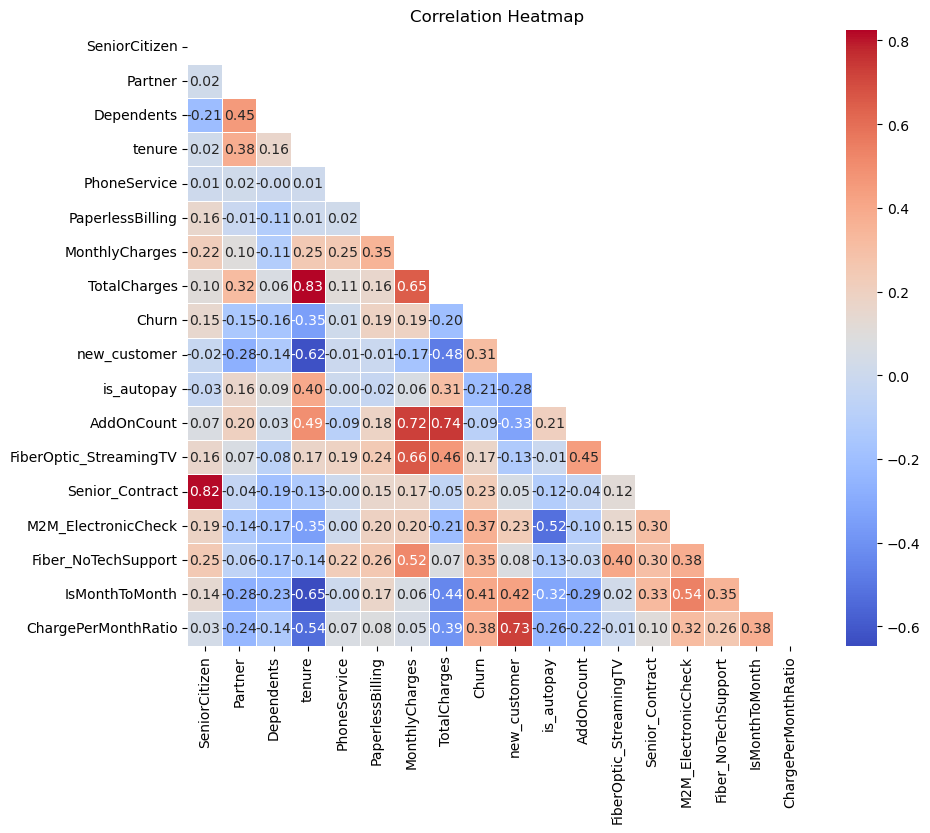

In [435]:
corr_matrix = data.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            cmap='coolwarm',
            fmt=".2f", 
            linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Features to drop
These features are going to be dropped since we have already engineered new features derived from these
- `TotalCharges`
- `MonthlyCharges`
- `tenure`
- `SeniorCitizen`
- `PaymentMethod`
- `PhoneService` (has very low correlation r=0.01)

In [436]:
data.drop(columns=['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen', 'PaymentMethod', 'PhoneService', 'gender'], inplace=True)

In [437]:
obj_cols = data.select_dtypes(include='object').columns
binary_cols = [col for col in obj_cols if data[col].nunique() == 2]
for col in binary_cols:
    data[col] = data[col].map({'No': 0, 'Yes': 1}).astype(int)

bool_cols = data.select_dtypes(include=["bool"]).columns
data[bool_cols] = data[bool_cols].astype(int)
data.head()

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,is_autopay,AddOnCount,AddOnGroup,FiberOptic_StreamingTV,Senior_Contract,MonthlyCharges_group,M2M_ElectronicCheck,Fiber_NoTechSupport,IsMonthToMonth,ChargePerMonthRatio
0,1,0,0,DSL,0,1,0,0,0,0,...,0,1,Low,0,0,Low,1,0,1,29.850
1,0,0,0,DSL,1,0,1,0,0,0,...,0,2,Low,0,0,Medium,0,0,0,1.675
2,0,0,0,DSL,1,1,0,0,0,0,...,0,2,Low,0,0,Medium,0,0,1,26.925
3,0,0,0,DSL,1,0,1,1,0,0,...,1,3,High,0,0,Medium,0,0,0,0.940
4,0,0,0,Fiber optic,0,0,0,0,0,0,...,0,0,None,0,0,High,1,1,1,35.350


In [438]:
cat_cols = list(data.select_dtypes(include=["object"]).columns) + list(data.select_dtypes(include=["category"]).columns)

In [439]:
data = pd.get_dummies(data, columns=cat_cols)

In [440]:
bool_cols = data.select_dtypes(include=["bool"]).columns
data[bool_cols] = data[bool_cols].astype(int)

In [441]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Partner                         7043 non-null   int64  
 1   Dependents                      7043 non-null   int64  
 2   MultipleLines                   7043 non-null   int64  
 3   OnlineSecurity                  7043 non-null   int64  
 4   OnlineBackup                    7043 non-null   int64  
 5   DeviceProtection                7043 non-null   int64  
 6   TechSupport                     7043 non-null   int64  
 7   StreamingTV                     7043 non-null   int64  
 8   StreamingMovies                 7043 non-null   int64  
 9   PaperlessBilling                7043 non-null   int64  
 10  Churn                           7043 non-null   int64  
 11  new_customer                    7043 non-null   int64  
 12  is_autopay                      70

## Feature Engineering Pipeline

In [442]:
df = pd.read_csv('../data/cleaned_data.csv')

In [443]:
from sklearn.preprocessing import StandardScaler

def feature_engineering(df: pd.DataFrame, output_path: str) -> pd.DataFrame:
    """Performs feature engineering on a telecom customer dataset and exports the result.

    This function applies a series of transformations to the input DataFrame, including
    creating new features, encoding categorical variables, and scaling numeric features.
    The transformed data is saved to a CSV file and returned for further use.

    Args:
        df (pd.DataFrame): Input DataFrame containing raw telecom customer data 
        output_path (str): File path where the engineered DataFrame will be saved as a CSV.

    Returns:
        pd.DataFrame: Transformed DataFrame with engineered features, one-hot encoded
            categorical variables, and scaled numeric columns
    """
    df = df.copy()
    churn =df['Churn']
    
    # Drop initial columns
    df.drop(columns=['gender'], inplace=True)
    
    # Tenure group
    df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 6, 12, 24, 48, 60, 72], 
                               labels=['0–6', '6–12', '12–24', '24–48', '48–60', '60–72'])
    df['new_customer'] = (df['tenure_group'] == '0–6').astype(int)
    
    # Payment and add-on features
    autopay_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
    df['is_autopay'] = df['PaymentMethod'].apply(lambda x: 1 if x in autopay_methods else 0)
    df['AddOnCount'] = (df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                           'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
    df['AddOnGroup'] = pd.cut(df['AddOnCount'], bins=[-1, 0, 2, 6], labels=['None', 'Low', 'High'])
    
    # Cost-related features
    df['ChargePerMonthRatio'] = df['MonthlyCharges'] / df['tenure'].replace(0, 1)
    df['MonthlyCharges_group'] = pd.cut(df['MonthlyCharges'], bins=[0, 40, 70, 100, np.inf], 
                                       labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Interaction terms
    df['Fiber_NoTechSupport'] = ((df['InternetService'] == 'Fiber optic') & (df['TechSupport'] == 'No')).astype(int)
    df['FiberOptic_StreamingTV'] = ((df['InternetService'] == 'Fiber optic') & (df['StreamingTV'] == 'Yes')).astype(int)
    df['Senior_Contract'] = ((df['SeniorCitizen'] == 1) & (df['Contract'] == 'Month-to-month')).astype(int)
    df['M2M_ElectronicCheck'] = ((df['Contract'] == 'Month-to-month') & (df['PaymentMethod'] == 'Electronic check')).astype(int)

    # Drop columns that are no longer needed
    df.drop(columns=['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen', 'PaymentMethod', 'PhoneService'], inplace=True)

    # Convert binary categorical columns (Yes/No) to 0/1
    obj_cols = df.select_dtypes(include='object').columns
    binary_cols = [col for col in obj_cols if df[col].nunique() == 2]
    for col in binary_cols:
        df[col] = df[col].map({'No': 0, 'Yes': 1}).astype(int)

    bool_cols = df.select_dtypes(include=["bool"]).columns
    df[bool_cols] = df[bool_cols].astype(int)

    # Perform one-hot encoding for remaining categorical columns
    encoded_cols = list(df.select_dtypes(include=["object"]).columns) + list(df.select_dtypes(include=["category"]).columns)
    df = pd.get_dummies(df, columns=encoded_cols, dtype=int)

    numeric_cols = ['ChargePerMonthRatio', 'AddOnCount']
    scaler = StandardScaler()
    scaler.fit_transform(df[numeric_cols])
    
    df.to_csv(output_path, index=False)
    return df

In [444]:
output_path = '../data/cleaned_engineered_data.csv'
feature_engineering(df, output_path)

,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,...,tenure_group_24–48,tenure_group_48–60,tenure_group_60–72,AddOnGroup_None,AddOnGroup_Low,AddOnGroup_High,MonthlyCharges_group_Low,MonthlyCharges_group_Medium,MonthlyCharges_group_High,MonthlyCharges_group_Very High
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,0
7039,1,1,1,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,0,1
7040,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
7041,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
